# Pricing Rainbow Options in the Multi-Dimensional Black-Scholes Model


## Change working directory to navigate out of folder. 

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

## Load Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
import pandas as pd
from IPython.display import display, HTML
from torch import nn
import torch.cuda
from collections import defaultdict
from sklearn.metrics import mean_squared_error

from GenerateMMDDataset.mmd_dataset_base import save_path_params, load_path_params

from StochasticModels.geometric_brownian_motion import BlackScholesExactSimulationSobolNDim, ConstantCorrelationCov

from RegressionModel.pricing_model import PricingModel
from RegressionModel.mmd_model import SecondOrderMMDApprox

from utils.plotting_functions import construct_scatter_plot

from MMD.mmd import RBFKernel, SigKernel

## Set PyTorch Device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.backends.cudnn.benchmark = True

Device: cuda


## Best-Call Rainbow Option Payoff

In [4]:
def BestCallRainbowPayoff(S, K, basketK):
    
    '''
    Compute the payoff of a rainbow option. 
    :param S: Asset Price at maturity. Array of dimension [Number of Simulations, Number of Assets].
    :param K: Asset-Strikes. Array of dimension [Number of Assets].
    :param basketK: The basket strike. 
    :return: Payoff at maturity. Array of dimension [Number of Simulations].
    '''
    
    return np.maximum(0, np.amax(np.divide(S[-1][:, :-1], K), 1)-basketK)
    
    
def PriceRainbowNDim(S0, K, basketK, r, sigmas, cov, T, num_sim, num_time_steps, 
                     scramble=True, decomp_needed=True, time_to_maturity=None):
    
    """
    Price rainbow options using Monte Carlo. 
    :param S0: Spot price. Array of dimension [Number of Assets].
    :param K: Asset-Strikes. Array of dimension [Number of Assets].
    :param basketK: The basket strike. 
    :param r: Risk-free interest rate. 
    :param sigmas: Individual volatilities. Array of dimension [Number of Assets].
    :param cov: Covariance matrix or Cholesky decomposition of covariance matrix.
                Array of dimension [Number of Assets, Number of Assets].
    :param T: Maturity. 
    :param num_sim: Number of simulations. 
    :param num_time_steps: Number of time-steps per simulation. 
    :param scramble: Indicates whether to scramble to Sobol sequences. Default is True. 
    :param decomp_needed: Indicates whether Cholesky decomposition is needed. Default is True. 
    :param time_to_maturity: (T-t) where t is the current time. 
    :return: Price of the rainbow option at time t. 
    """
    
    S1 = BlackScholesExactSimulationSobolNDim(S0, r, sigmas, cov, T, num_sim, num_time_steps, decomp_needed)
    payoff = BestCallRainbowPayoff(S1, K, basketK)
    return np.exp(-r*T)*np.average(payoff) if time_to_maturity is None else np.exp(-r*time_to_maturity)*np.average(payoff)

### Load Pre-trained MMD model. 

In [5]:
multi_gbm_mmd_input_dimension = 8

multi_gbm_mmd_model_param_dict = {
    'input_dimension' : multi_gbm_mmd_input_dimension,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
    'add_layer_norm' : [False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None
}

multi_gbm_second_order_mmd_model = SecondOrderMMDApprox(multi_gbm_mmd_model_param_dict, 
                                                        None,
                                                        None, None, device,
                                                        'Multi GBM/MMD Model/multi_gbm_mmd_scaler_1.pkl')

multi_gbm_second_order_mmd_model.load_best_model('Multi GBM/MMD Model/multi_gbm_mmd_model_best_1.pth.tar', 
                                                 'Multi GBM/MMD Model/multi_gbm_mmd_scaler_1.pkl')

## Generate dataset

In [18]:
corr_range = (0.05, 0.95)
M = 50000
N = 20
_round = 5


S0_range = (50, 80)
strike_range = (30, 110)
r_range = (0.01, 0.1)
r_round = 5

multi_gbm_num_sim = 20000
multi_gbm_num_time_steps = 1

T_list = np.random.randint(1, 5, M)

dim = 3

multi_gbm_sigma_list = [np.random.uniform(0.2, 0.8, dim) for _ in range(M)]
multi_gbm_correlations = np.random.uniform(corr_range[0], corr_range[1], M)

S0_multi_gbm = [np.random.randint(S0_range[0], S0_range[1], dim) for _ in range(M)]
r_multi_gbm = np.round(np.random.uniform(r_range[0], r_range[1], M), r_round)
basket_strike_multi_gbm = np.round(np.random.uniform(0.25, 1, M), _round)
strikes_multi_gbm = [np.random.randint(strike_range[0], strike_range[1], dim) for _ in range(M)]


multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K = []
multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K = []

multi_gbm_second_order_mmd_model.model.eval()
with torch.no_grad():
    for i in tqdm(range(M)):
        correlation = multi_gbm_correlations[i]
        sigmas = multi_gbm_sigma_list[i]
        cov = ConstantCorrelationCov(sigmas, correlation)
        r = r_multi_gbm[i]
        S0 = S0_multi_gbm[i]
        basket_strike = basket_strike_multi_gbm[i]
        strikes = strikes_multi_gbm[i]
        T = T_list[i]
        
        
        new_features = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_sigma_list[j][int(k/2)] for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_correlations[j]]
            new_features.append(multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
        
        for i in range(dim):
            new_features.append(S0[i])
            new_features.append(strikes[i])
        
        new_features.append(basket_strike)
        new_features.append(r)
        new_features.append(T)

        multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K.append(new_features)
        
        
        multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K.append(PriceRainbowNDim(S0, strikes, basket_strike, r, sigmas, cov,
                                                                                 T, multi_gbm_num_sim, base_steps))

  0%|          | 0/50000 [00:00<?, ?it/s]

### Save the Dataset

In [52]:
length = len(multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K)
l = int(length/5)
sub_features = []
for i in range(5):
    sub_features.append(multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K[i*l:(i+1)*l])
    
features_file_name_base = "Multi GBM/Data/multi_gbm_rainbow_best_call_features_diff_T_diff_K"

for i in range(5):
    with open(f'{features_file_name_base}_part_{i+1}', "wb") as fp:
        pickle.dump(sub_features[i], fp)
    
with open("Multi GBM/Data/multi_gbm_rainbow_best_call_labels_diff_T_diff_K", "wb") as fp:
    pickle.dump(multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K, fp)
    

multi_gbm_rainbow_best_call_pricer_dict_diff_K = {
    'M' : M,
    'N' : N,
    'S0 Range' : S0_range, 
    'S0' : S0_multi_gbm,
    'Strike Range' : strike_range,
    'Strikes' : strikes_multi_gbm,
    'Basket Strike Range' : (0.25, 1),
    'Basket Strike' : basket_strike_multi_gbm,
    'r Range' : r_range,
    'r' : r_multi_gbm,
    'r round' : r_round, 
    'T' : T_list,
    'Dim' : dim, 
    'Sigma List' : multi_gbm_sigma_list,
    'Correlation List' : multi_gbm_correlations,
    'Sigma Range' : (0.2, 0.8),
    'Correlation Range' : corr_range,
    'Num Sim' : multi_gbm_num_sim,
    'Num Time Steps' : 1,
    '_round' : _round
}
    
save_path_params(multi_gbm_rainbow_best_call_pricer_dict_diff_K, "Multi GBM/Data/multi_gbm_rainbow_best_call_dict_diff_K")

### Load Dataset

In [3]:
features_file_name_base = "Multi GBM/Data/multi_gbm_rainbow_best_call_features_diff_T_diff_K"
multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K = []

for i in range(5):
    with open(f'{features_file_name_base}_part_{i+1}', 'rb') as f:
            multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K += pickle.load(f)
        
with open("Multi GBM/Data/multi_gbm_rainbow_best_call_labels_diff_T_diff_K", 'rb') as f:
        multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K = pickle.load(f)
        

In [7]:
multi_gbm_rainbow_best_call_pricer_dict_diff_K = load_path_params("Multi GBM/Data/multi_gbm_rainbow_best_call_dict_diff_K")

### Train the Model

In [ ]:
multi_gbm_rainbow_best_call_diff_k_training_param_dict = {
    'lr' : 0.005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}

multi_gbm_rainbow_best_call_dataset_diff_k_loader_params = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}

N = multi_gbm_rainbow_best_call_pricer_dict_diff_K['N']
dim = multi_gbm_rainbow_best_call_pricer_dict_diff_K['Dim']


multi_gbm_rainbow_best_call_diff_K_input_dimension = N+((dim+1)*2)+1

multi_gbm_rainbow_best_call_model_param_diff_K_dict = {
    'input_dimension' : multi_gbm_rainbow_best_call_diff_K_input_dimension,
    'intermediate_dimensions' : [75, 75, 75, 75],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


for k in [1, 5, 10, 15, 20]:
    
    
    N = k


    multi_gbm_rainbow_best_call_diff_K_input_dimension = N+((dim+1)*2)+1

    multi_gbm_rainbow_best_call_model_param_diff_K_dict = {
        'input_dimension' : multi_gbm_rainbow_best_call_diff_K_input_dimension,
        'intermediate_dimensions' : [75, 75, 75, 75],
        'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
        'add_layer_norm' : [False, False, False, False, False],
        'output_dimension' : 1,
        'output_activation_fn' : None,
        'use_input_layer_norm' : False,
        'use_output_layer_norm' : False,
        'use_residual' : False
    }

    
    for i in range(5):


        multi_gbm_rainbow_best_call_diff_k_pricing_model = PricingModel(multi_gbm_rainbow_best_call_model_param_diff_K_dict, 
                                                    multi_gbm_rainbow_best_call_diff_k_training_param_dict, 
                                                    multi_gbm_rainbow_best_call_dataset_diff_k_loader_params, nn.MSELoss(), device,
                                                    f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_scaler_diff_T_{k}_dist_diff_k_{i+1}.pkl', 
                                                    multi_gbm_rainbow_best_call_diff_K_input_dimension, 
                                                    scheduler_gamma=0.75, use_scheduler=True, 
                                                    milestones=[50, 70, 90, 100, 110, 120, 130, 135, 140, 145, 150, 155,
                                                                160, 165, 170, 175, 180, 185, 190, 195])
        
               
        multi_gbm_rainbow_best_call_diff_k_pricing_model.fit(torch.tensor(multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K)[:, 20-k:].float(), 
                                     torch.tensor(multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K).float(), 
                                     **{'filename' : f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_checkpoint_diff_T_{k}_dist_diff_k_{i+1}.pth.tar', 
                                        'best_model_filename' : f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_{k}_dist_diff_k_{i+1}.pth.tar'})

In [6]:
train_losses_dict = defaultdict(list)

for k in [1, 5, 10, 15, 20]:
    
    for i in range(5):
        checkpoint = torch.load(f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_{k}_dist_diff_k_{i+1}.pth.tar', map_location='cpu')
        train_losses_dict[k].append(checkpoint['train_loss'])
        
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(train_losses_dict[k]))
    print(np.std(train_losses_dict[k]))

********************  1 ********************
0.015492928214371204
2.203965498188936e-05
********************  5 ********************
0.001008849125355482
4.784782951119418e-06
********************  10 ********************
0.00039056139648891987
9.440544544426252e-06
********************  15 ********************
0.00036063557490706444
1.0321888808808262e-05
********************  20 ********************
0.0003412000194657594
1.0095592948364033e-05


In [8]:
valid_losses_dict = defaultdict(list)

for k in [1, 5, 10, 15, 20]:
    
    for i in range(5):
            checkpoint = torch.load(f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_{k}_dist_diff_k_{i+1}.pth.tar', map_location='cpu')
            valid_losses_dict[k].append(checkpoint['valid_loss'])
            
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(valid_losses_dict[k]))
    print(np.std(valid_losses_dict[k]))

********************  1 ********************
0.01590883806347847
0.00014601912179985113
********************  5 ********************
0.0011433492647483945
2.949741372624608e-05
********************  10 ********************
0.00045101019204594193
1.865647701577847e-05
********************  15 ********************
0.0004227383004035801
1.218539447153032e-05
********************  20 ********************
0.00039252088754437864
1.631588563558339e-05


### Train Baseline

In [ ]:
multi_gbm_rainbow_best_call_diff_k_training_param_dict_no_dist = {
    'lr' : 0.005,
    'Epochs' : 200,
    'l2_weight' : 0.0001,
    'l1_weight' : 0.0,
    'Train/Val Split' : 0.8,
    'exp_sigma' : 2
}

multi_gbm_rainbow_best_call_dataset_diff_k_loader_params_no_dist = {
    'batch_size' : 256,
    'shuffle' : True,
    'num_workers' : 0
}


multi_gbm_rainbow_best_call_diff_K_input_dimension_no_dist = 13


multi_gbm_rainbow_best_call_model_param_diff_K_dict_no_dist = {
    'input_dimension' : multi_gbm_rainbow_best_call_diff_K_input_dimension_no_dist,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], # List of length equal to the number of hidden units
    'add_layer_norm' : [False, False, False, False, False], # List of length equal to 1 - Num. Hidden Units
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


multi_gbm_sigma_list = multi_gbm_rainbow_best_call_pricer_dict_diff_K['Sigma List']
multi_gbm_correlations = multi_gbm_rainbow_best_call_pricer_dict_diff_K['Correlation List']
new_features = []
for i in range(len(multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K)):
    new_features.append(multi_gbm_sigma_list[i].tolist() + [multi_gbm_correlations[i]] + multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K[i][20:])

for i in range(5):
    
    multi_gbm_rainbow_best_call_diff_k_pricing_model_no_dist = PricingModel(multi_gbm_rainbow_best_call_model_param_diff_K_dict_no_dist, 
                                            multi_gbm_rainbow_best_call_diff_k_training_param_dict_no_dist, 
                                            multi_gbm_rainbow_best_call_dataset_diff_k_loader_params_no_dist, nn.MSELoss(), device,
                                            f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_scaler_diff_T_diff_k_no_dist_{i+1}.pkl', 
                                            multi_gbm_rainbow_best_call_diff_K_input_dimension_no_dist, 
                                            scheduler_gamma=0.9, use_scheduler=True, 
                                            milestones=[50, 70, 90, 100, 110, 120, 130, 135, 140, 145, 150, 155,
                                                        160, 165, 170, 175, 180, 185, 190, 195])
    
    multi_gbm_rainbow_best_call_diff_k_pricing_model_no_dist.fit(torch.tensor(new_features).float(), 
                                 torch.tensor(multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K).float(), 
                                 **{'filename' : f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_checkpoint_diff_T_diff_k_no_dist_{i+1}.pth.tar', 
                                    'best_model_filename' : f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_diff_k_no_dist_{i+1}.pth.tar'})

In [10]:
train_losses = []
valid_losses = []
    
for i in range(5):
    checkpoint = torch.load(f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_diff_k_no_dist_{i+1}.pth.tar', map_location='cpu')
    train_losses.append(checkpoint['train_loss'])
    valid_losses.append(checkpoint['valid_loss'])

print(f'Training Loss')
print(np.mean(train_losses))
print(np.std(train_losses))
print(f'Validation Loss')
print(np.mean(valid_losses))
print(np.std(valid_losses))

Training Loss
0.0005246127024292946
2.239640437802413e-05
Validation Loss
0.000539826333988458
2.7503894995010365e-05


## Test the Model

In [28]:
corr_range = (0.05, 0.95)
M = 2000
N = 20
_round = 5


S0_range = (50, 80)
strike_range = (30, 110)
r_range = (0.01, 0.1)
r_round = 5

multi_gbm_num_sim = 20000
multi_gbm_num_time_steps = 1

T_list = np.random.randint(1, 5, M)

dim = 3

multi_gbm_sigma_list = [np.random.uniform(0.2, 0.8, dim) for _ in range(M)]
multi_gbm_correlations = np.random.uniform(corr_range[0], corr_range[1], M)

S0_multi_gbm = [np.random.randint(S0_range[0], S0_range[1], dim) for _ in range(M)]
r_multi_gbm = np.round(np.random.uniform(r_range[0], r_range[1], M), r_round)
basket_strike_multi_gbm = np.round(np.random.uniform(0.25, 1, M), _round)
strikes_multi_gbm = [np.random.randint(strike_range[0], strike_range[1], dim) for _ in range(M)]


multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K = []
multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K = []

multi_gbm_second_order_mmd_model.model.eval()
with torch.no_grad():
    for i in tqdm(range(M)):
        correlation = multi_gbm_correlations[i]
        sigmas = multi_gbm_sigma_list[i]
        cov = ConstantCorrelationCov(sigmas, correlation)
        r = r_multi_gbm[i]
        S0 = S0_multi_gbm[i]
        basket_strike = basket_strike_multi_gbm[i]
        strikes = strikes_multi_gbm[i]
        T = T_list[i]
        
        
        new_features = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_rainbow_best_call_pricer_dict_diff_K['Sigma List'][j][int(k/2)] for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_rainbow_best_call_pricer_dict_diff_K['Correlation List'][j]]
            new_features.append(multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
        
        for i in range(dim):
            new_features.append(S0[i])
            new_features.append(strikes[i])
        
        new_features.append(basket_strike)
        new_features.append(r)
        new_features.append(T)

        multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K.append(new_features)
        
        
        multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K.append(PriceRainbowNDim(S0, strikes, basket_strike, r, sigmas, cov,
                                                                                 T, multi_gbm_num_sim, multi_gbm_num_time_steps))

  0%|          | 0/2000 [00:00<?, ?it/s]

### SPEEDRS

In [38]:
test_losses_dict = defaultdict(list)



for k in [1, 5, 10, 15, 20]:
    
    input_dimension = k+((dim+1)*2)+1

    architecture = {
        'input_dimension' : input_dimension,
        'intermediate_dimensions' : [75, 75, 75, 75],
        'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
        'add_layer_norm' : [False, False, False, False, False], 
        'output_dimension' : 1,
        'output_activation_fn' : None,
        'use_input_layer_norm' : False,
        'use_output_layer_norm' : False,
        'use_residual' : False
    }

    
     speedrs_pricing_model = PricingModel(architecture,
                                          None,
                                          None,
                                          None,
                                          device,
                                          None,
                                          input_dimension)
    
        
    for i in range(5):

        speedrs_pricing_model.load_best_model(f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_{k}_dist_diff_k_{i+1}.pth.tar', 
                                              f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_scaler_diff_T_{k}_dist_diff_k_{i+1}.pkl')
        
        features = torch.tensor(multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K).float()[:, 20-k:]
        speedrs_pricing_model.model.eval()
        with torch.no_grad():
            test_losses_dict[k].append(mean_squared_error(speedrs_pricing_model.transform(features).cpu(), multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K))
        
    print(f'{"*"*20}  {k} {"*"*20}')
    print(np.mean(test_losses_dict[k]))
    print(np.std(test_losses_dict[k]))

********************  1 ********************
0.016170803817228678
7.958183109977958e-05
********************  5 ********************
0.0011885897332725678
1.1059721903351242e-05
********************  10 ********************
0.0004618853785023974
2.1451274116351584e-05
********************  15 ********************
0.0004257701356974575
8.266745754820224e-06
********************  20 ********************
0.00040185967181543034
1.794337827461039e-05


### Baseline

In [41]:
input_dimension = 13


architecture = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [30, 30, 30, 30],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'add_layer_norm' : [False, False, False, False, False],
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


features = []
for i in range(len(multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K)):
    features.append(multi_gbm_sigma_list[i].tolist() + [multi_gbm_correlations[i]] + multi_gbm_rainbow_best_call_pricing_features_diff_T_diff_K[i][20:])
    

features = np.asarray(features)
test_losses = []

for i in range(5):
    
    basline_pricing_model = PricingModel(architecture
                                         None,
                                         None,
                                         None,
                                         device, 
                                         None,
                                         input_dimension)


    basline_pricing_model.load_best_model(f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_diff_k_no_dist_{i+1}.pth.tar', 
                                          f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_scaler_diff_T_diff_k_no_dist_{i+1}.pkl')

    
    basline_pricing_model.model.eval()
    with torch.no_grad():
        test_losses.append(mean_squared_error(basline_pricing_model.transform(torch.tensor(features).float()).cpu(), multi_gbm_rainbow_best_call_pricing_labels_diff_T_diff_K))
        
print(np.mean(test_losses))
print(np.std(test_losses))

0.0005506120232259059
2.30577270484882e-05


### SPEEDRS - Out of Sample Tests

In [6]:
dim = 3
N = 20
input_dimension = 20+((dim+1)*2)+1

architecture = {
    'input_dimension' : input_dimension,
    'intermediate_dimensions' : [75, 75, 75, 75],
    'activation_functions' : [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()],
    'add_layer_norm' : [False, False, False, False, False], 
    'output_dimension' : 1,
    'output_activation_fn' : None,
    'use_input_layer_norm' : False,
    'use_output_layer_norm' : False,
    'use_residual' : False
}


speedrs_pricing_model = PricingModel(architecture,
                                     None,
                                     None,
                                     None,
                                     device,
                                     None,
                                     input_dimension)
    
speedrs_pricing_model.load_best_model(f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_pricer_model_best_diff_T_20_dist_diff_k_5.pth.tar', 
                                      f'Multi GBM/Pricer Model/multi_gbm_rainbow_best_call_scaler_diff_T_20_dist_diff_k_5.pkl')


multi_gbm_rainbow_best_call_pricer_dict_diff_K = load_path_params("Multi GBM/Data/multi_gbm_rainbow_best_call_dict_diff_K")

test_data_dict = {}

Vary $K_{B}$ and keep all other parameters fixed. 

In [7]:
sigmas = np.round(np.random.uniform(0.2, 0.8, dim), 2)
correlation = 0.4
cov1 = ConstantCorrelationCov(sigmas, correlation)

T = 3
r = 0.015

multi_gbm_num_sim = 50000
multi_gbm_num_time_steps = 1


s0 = [65, 59, 75]
strikes = [34, 54, 90]
basket_strikes = np.round(np.linspace(0.25, 1, 20), 2)

approximate_prices = []

multi_gbm_rainbow_best_call_monte_carlo_prices_basket = []


for basket_strike in tqdm(basket_strikes):
                    
    multi_gbm_rainbow_best_call_monte_carlo_prices_basket.append(PriceRainbowNDim(s0, strikes, basket_strike, r, sigmas, cov1,
                                                                                 T, multi_gbm_num_sim, 
                                                                                 multi_gbm_num_time_steps))
    
    multi_gbm_second_order_mmd_model.model.eval()
    speedrs_pricing_model.model.eval()
    with torch.no_grad():
        test_inputs = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_rainbow_best_call_pricer_dict_diff_K['Sigma List'][j][int(k/2)] for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_rainbow_best_call_pricer_dict_diff_K['Correlation List'][j]]
            test_inputs.append(multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
    
        for i in range(dim):
            test_inputs.append(s0[i])
            test_inputs.append(strikes[i])

        test_inputs.append(basket_strike)
        test_inputs.append(r)
        test_inputs.append(T)
        
        approximate_price = speedrs_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price.cpu().item())
        

results_df = pd.DataFrame({r'$K_{B}$' : basket_strikes, 'Price NN' : approximate_prices, 'MC Price' : multi_gbm_rainbow_best_call_monte_carlo_prices_basket})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'), 
                            torch.tensor(multi_gbm_rainbow_best_call_monte_carlo_prices_basket).to(device='cpu'))
print(f'MSE NN: {mse_nn}')


test_data_dict['K_B'] = [basket_strikes, approximate_prices, multi_gbm_rainbow_best_call_monte_carlo_prices_basket]

  0%|          | 0/20 [00:00<?, ?it/s]

,$K_{B}$,Price NN,MC Price
0,0.25,2.184454,2.204274
1,0.29,2.153597,2.166509
2,0.33,2.122011,2.129096
3,0.37,2.090383,2.092147
4,0.41,2.058754,2.055760
5,0.45,2.026519,2.020026
6,0.49,1.993809,1.985029
7,0.53,1.961099,1.950818
8,0.57,1.930929,1.917433
9,0.61,1.899491,1.884910


MSE NN: 9.98221160043373e-05


Vary T whilst keeping the other parameters fixed. 

In [8]:
sigmas = [0.26, 0.58, 0.29]
correlation = 0.56
cov1 = ConstantCorrelationCov(sigmas, correlation)

T_list = [1, 2, 3, 4, 5]
r = 0.015

multi_gbm_num_sim = 20000
multi_gbm_num_time_steps = 1

s0 = [67, 66, 56]
strikes = [98, 98, 98]
basket_strike = 0.56

approximate_prices = []

multi_gbm_rainbow_best_call_monte_carlo_prices_T = []


for T in tqdm(T_list):
                    
    multi_gbm_rainbow_best_call_monte_carlo_prices_T.append(PriceRainbowNDim(s0, strikes, basket_strike, r, sigmas, cov1,
                                                                                 T, multi_gbm_num_sim, 
                                                                                 multi_gbm_num_time_steps))
    
    multi_gbm_second_order_mmd_model.model.eval()
    speedrs_pricing_model.model.eval()
    with torch.no_grad():
        test_inputs = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else multi_gbm_rainbow_best_call_pricer_dict_diff_K['Sigma List'][j][int(k/2)] for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_rainbow_best_call_pricer_dict_diff_K['Correlation List'][j]]
            test_inputs.append(multi_gbm_second_order_mmd_model.transform(torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
    
        for i in range(dim):
            test_inputs.append(s0[i])
            test_inputs.append(strikes[i])

        test_inputs.append(basket_strike)
        test_inputs.append(r)
        test_inputs.append(T)
        
        approximate_price = speedrs_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price.cpu().item())
        

results_df = pd.DataFrame({r'T' : T_list, 'Price NN' : approximate_prices, 'MC Price' : multi_gbm_rainbow_best_call_monte_carlo_prices_T})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'), 
                            torch.tensor(multi_gbm_rainbow_best_call_monte_carlo_prices_T).to(device='cpu'))
print(f'MSE NN: {mse_nn}')

test_data_dict['T'] = [T_list, approximate_prices, multi_gbm_rainbow_best_call_monte_carlo_prices_T]

  0%|          | 0/5 [00:00<?, ?it/s]

,T,Price NN,MC Price
0,1,0.308014,0.280134
1,2,0.379243,0.365158
2,3,0.436269,0.433283
3,4,0.479828,0.491744
4,5,0.555046,0.543575


MSE NN: 0.0002516402707271561


Vary the correlation whilst keeping the other parameters fixed. 

In [9]:
sigmas = np.round(np.random.uniform(0.2, 0.8, dim), 2)
correlation_list = np.round(np.linspace(0.05, 0.95, 30), 2)

T = 1
r = 0.05

multi_gbm_num_sim = 20000
multi_gbm_num_time_steps = 1


s0 = [55, 65, 75]
strikes = [75, 65, 55]
basket_strike = 0.85

approximate_prices = []

multi_gbm_rainbow_best_call_monte_carlo_prices_corr = []


for correlation in tqdm(correlation_list):
    
    cov1 = ConstantCorrelationCov(sigmas, correlation)
                    
    # MC Call Price
    multi_gbm_rainbow_best_call_monte_carlo_prices_corr.append(PriceRainbowNDim(s0, strikes, basket_strike, r, sigmas, 
                                                                                cov1, T, multi_gbm_num_sim, 
                                                                                multi_gbm_num_time_steps))
    
    multi_gbm_second_order_mmd_model.model.eval()
    speedrs_pricing_model.model.eval()
    with torch.no_grad():
        test_inputs = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else 
                         multi_gbm_rainbow_best_call_pricer_dict_diff_K['Sigma List'][j][int(k/2)] for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_rainbow_best_call_pricer_dict_diff_K['Correlation List'][j]]
            test_inputs.append(multi_gbm_second_order_mmd_model.transform(
                torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
    
        for i in range(dim):
            test_inputs.append(s0[i])
            test_inputs.append(strikes[i])

        test_inputs.append(basket_strike)
        test_inputs.append(r)
        test_inputs.append(T)
        
        approximate_price = speedrs_pricing_model.transform(
            torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price[0][0].cpu().item())
        

results_df = pd.DataFrame({r'Correlation' : correlation_list, 'Price NN' : approximate_prices,
                           'MC Price' : multi_gbm_rainbow_best_call_monte_carlo_prices_corr})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'),
                            torch.tensor(multi_gbm_rainbow_best_call_monte_carlo_prices_corr).to(device='cpu'))
print(f'MSE NN: {mse_nn}')

test_data_dict['Correlation'] = [correlation_list, approximate_prices, multi_gbm_rainbow_best_call_monte_carlo_prices_corr]

  0%|          | 0/30 [00:00<?, ?it/s]

,Correlation,Price NN,MC Price
0,0.05,0.939637,0.933684
1,0.08,0.933747,0.927311
2,0.11,0.926809,0.920853
3,0.14,0.919552,0.914307
4,0.17,0.912878,0.907703
5,0.21,0.904061,0.898760
6,0.24,0.897922,0.891917
7,0.27,0.891956,0.884972
8,0.30,0.886893,0.877919
9,0.33,0.882548,0.870725


MSE NN: 0.00011255888151819756


Vary $\sigma_{1}$ whilst keeping the other parameters fixed. 

In [10]:
sigma_1_list = np.round(np.linspace(0.2, 0.8, 20), 2)
sigma_2 = 0.45
sigma_3 = 0.36
correlation = 0.8

T = 3
r = 0.05

multi_gbm_num_sim = 20000
multi_gbm_num_time_steps = 1


s0 = [68, 68, 79]
strikes = [45, 98, 56]
basket_strike = 0.67

approximate_prices = []

multi_gbm_rainbow_best_call_monte_carlo_prices_sigma_1 = []


for sigma_1 in tqdm(sigma_1_list):
    
    sigmas = [sigma_1, sigma_2, sigma_3]
    
    cov1 = ConstantCorrelationCov(sigmas, correlation)
                    
    multi_gbm_rainbow_best_call_monte_carlo_prices_sigma_1.append(PriceRainbowNDim(s0, strikes, basket_strike, r, sigmas, 
                                                                                cov1, T, multi_gbm_num_sim, 
                                                                                multi_gbm_num_time_steps))
    
    multi_gbm_second_order_mmd_model.model.eval()
    speedrs_pricing_model.model.eval()
    with torch.no_grad():
        test_inputs = []
        for j in range(N):
            mmd_input = [sigmas[int(k/2)] if k%2 == 0 else 
                         multi_gbm_rainbow_best_call_pricer_dict_diff_K['Sigma List'][j][int(k/2)] for k in range(2*dim)]
            mmd_input += [correlation, multi_gbm_rainbow_best_call_pricer_dict_diff_K['Correlation List'][j]]
            test_inputs.append(multi_gbm_second_order_mmd_model.transform(
                torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))
    
        for i in range(dim):
            test_inputs.append(s0[i])
            test_inputs.append(strikes[i])

        test_inputs.append(basket_strike)
        test_inputs.append(r)
        test_inputs.append(T)
        
        approximate_price = speedrs_pricing_model.transform(
            torch.tensor(test_inputs).unsqueeze(0).float())
        approximate_prices.append(approximate_price[0][0].cpu().item())
        

results_df = pd.DataFrame({r'$\sigma_{1}$' : sigma_1_list, 'Price NN' : approximate_prices,
                           'MC Price' : multi_gbm_rainbow_best_call_monte_carlo_prices_sigma_1})
display(HTML(results_df.to_html()))
    
    
mse_nn = mean_squared_error(torch.tensor(approximate_prices).to(device='cpu'),
                            torch.tensor(multi_gbm_rainbow_best_call_monte_carlo_prices_sigma_1).to(device='cpu'))
print(f'MSE NN: {mse_nn}')

test_data_dict['Sigma1'] = [sigma_1_list, approximate_prices, multi_gbm_rainbow_best_call_monte_carlo_prices_sigma_1]

  0%|          | 0/20 [00:00<?, ?it/s]

,$\sigma_{1}$,Price NN,MC Price
0,0.20,1.148493,1.127167
1,0.23,1.145514,1.117945
2,0.26,1.140299,1.112880
3,0.29,1.137365,1.112325
4,0.33,1.139193,1.118328
5,0.36,1.143941,1.127392
6,0.39,1.157903,1.139800
7,0.42,1.170668,1.155143
8,0.45,1.186618,1.172656
9,0.48,1.201975,1.191971


MSE NN: 0.0002526873117983037


Plot results. 

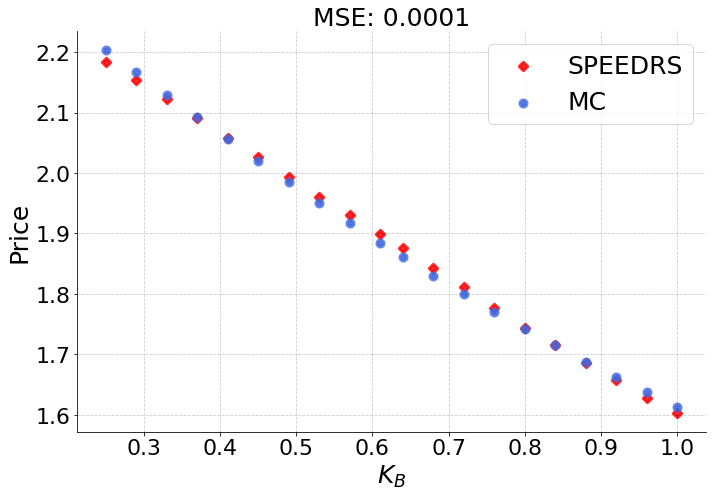

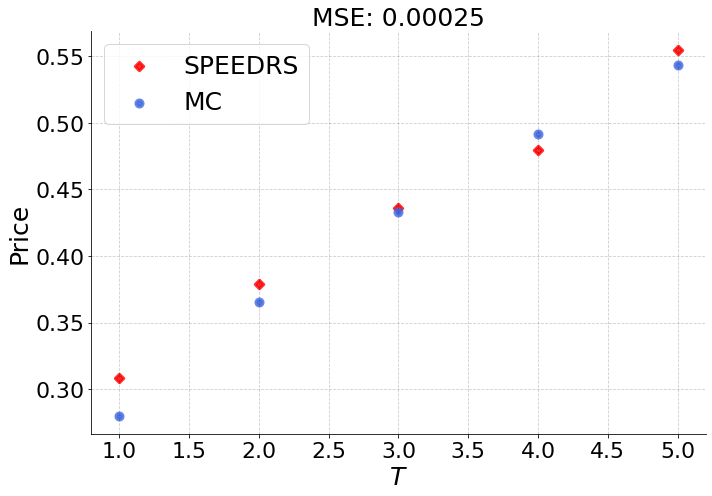

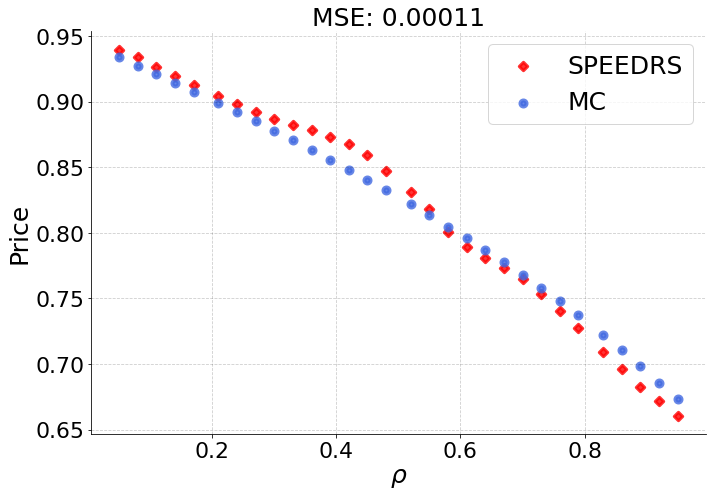

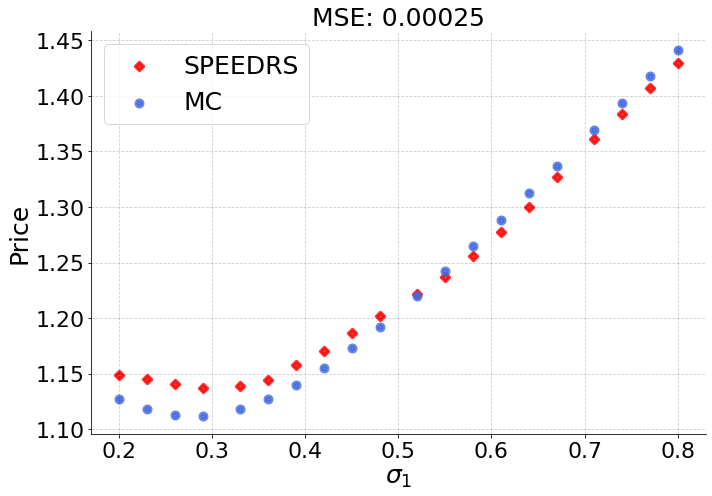

In [11]:
labels = ['SPEEDRS', 'MC']
markers = ['D', 'o']
alphas = [0.8, 0.8]
linewidths = [3.0, 4.0]
colors = ['red', 'royalblue']
ylabel = 'Price'

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['K_B'][0], test_data_dict['K_B'][1], test_data_dict['K_B'][2], 
                       labels, markers, colors, alphas, linewidths, r'$K_B$', ylabel, r=5)

plt.tight_layout()
filename = 'Multi GBM/Images/rainbow_test_plots_KB.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['T'][0], test_data_dict['T'][1], test_data_dict['T'][2], 
                       labels, markers, colors, alphas, linewidths, r'$T$', ylabel, r=5)

plt.tight_layout()
filename = 'Multi GBM/Images/rainbow_test_plots_T.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()


fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['Correlation'][0], test_data_dict['Correlation'][1], test_data_dict['Correlation'][2], 
                       labels, markers, colors, alphas, linewidths, r'$\rho$', ylabel, r=5)

plt.tight_layout()
filename = 'Multi GBM/Images/rainbow_test_plots_rho.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

construct_scatter_plot(ax, test_data_dict['Sigma1'][0], test_data_dict['Sigma1'][1], test_data_dict['Sigma1'][2], 
                       labels, markers, colors, alphas, linewidths, r'$\sigma_1$', ylabel, r=5)

plt.tight_layout()
filename = 'Multi GBM/Images/rainbow_test_plots_sigma1.svg'
plt.savefig(f'{filename}', bbox_inches='tight', format='svg', dpi=1200)
plt.show()


## Test Run-Time

In [156]:
%%timeit
T=5
cov1 = ConstantCorrelationCov(sigmas, correlation)
PriceRainbowNDim(s0, strikes, basket_strike, r, sigmas, cov1, T, 20000, 50, bestWorst, callPut)

325 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
%%timeit

multi_gbm_second_order_mmd_model.model.eval()
multi_gbm_rainbow_best_call_diff_k_pricing_model.model.eval()
with torch.no_grad():
    test_inputs = []
    for j in range(N):
        mmd_input = [sigmas[int(k/2)] if k%2 == 0 else 
                     multi_gbm_rainbow_best_call_pricer_dict_diff_K['Sigma List'][j][int(k/2)] for k in range(2*dim)]
        mmd_input += [correlation, multi_gbm_rainbow_best_call_pricer_dict_diff_K['Correlation List'][j]]
        test_inputs.append(multi_gbm_second_order_mmd_model.transform(
            torch.tensor(mmd_input).unsqueeze(0).float()).squeeze(0).squeeze(0))

    for i in range(dim):
        test_inputs.append(s0[i])
        test_inputs.append(strikes[i])

    test_inputs.append(basket_strike)
    test_inputs.append(r)
    test_inputs.append(T)

    multi_gbm_rainbow_best_call_diff_k_pricing_model.transform(torch.tensor(test_inputs).unsqueeze(0).float())

13.8 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [158]:
%%timeit

multi_gbm_second_order_mmd_model.model.eval()
with torch.no_grad():
    multi_gbm_second_order_mmd_model.transform(
            torch.tensor([sigmas[0], sigmas[0], sigmas[1], sigmas[1], sigmas[2], sigmas[2], correlation, correlation]).unsqueeze(0).float())

780 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
static_kernel_21 = RBFKernel(sigma=50)
static_kernel_22 = RBFKernel(sigma=0.5)

dyadic_order = 0

lambda_ = 1e-5

signature_kernel = SigKernel([static_kernel_21, static_kernel_22], dyadic_order)

num_sim = 200
num_time_steps = 24

In [7]:
%%timeit

cov1 = ConstantCorrelationCov(sigmas, correlation)
cov2 = ConstantCorrelationCov(sigmas, correlation)

path1 = torch.transpose(torch.from_numpy(BlackScholesExactSimulationSobolNDim([0.5, 0.5, 0.5], 0.0, sigmas, cov1, 1, num_sim, num_time_steps, True)), 0, 1).to(device=device)
path2 = torch.transpose(torch.from_numpy(BlackScholesExactSimulationSobolNDim([0.5, 0.5, 0.5], 0.0, sigmas, cov2, 1, num_sim, num_time_steps, True)), 0, 1).to(device=device)

signature_kernel.compute_mmd(path1, path2, lambda_=lambda_, estimator='ub', order=2)

5.77 s ± 32.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
